In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
from keras.models import load_model

In [ ]:
import pandas as pd

# Path to your CSV files
train_file_path = '/content/drive/MyDrive/UNSW-NB-15-dataset/UNSW_NB15_training-set.csv'
test_file_path = '/content/drive/MyDrive/UNSW-NB-15-dataset/UNSW_NB15_testing-set.csv'

# Load the datasets
train_df = pd.read_csv("/content/drive/MyDrive/UNSW-NB-15-dataset/UNSW_NB15_training-set.csv")
test_df = pd.read_csv("/content/drive/MyDrive/UNSW-NB-15-dataset/UNSW_NB15_testing-set.csv")

# Combine the datasets
data = pd.concat([train_df, test_df], ignore_index=True)

data.head()



,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Identify the target variable
categorical_target = 'attack_cat'
binary_target = 'label'

# Initialize the label encoder
label_encoder = LabelEncoder()

# Apply label encoding to the target variable
if categorical_target in data.columns:
    data[categorical_target] = label_encoder.fit_transform(data[categorical_target])

# Apply label encoding to each categorical feature
for col in data.select_dtypes(include=['object']).columns:
    data[col] = label_encoder.fit_transform(data[col])





In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply normalization to numerical features excluding the target variables
features_to_scale = data.columns.difference([categorical_target, binary_target])
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])



In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Bidirectional, LSTM, MultiHeadAttention, GlobalAveragePooling1D



# Assume 'binary_target' and 'multi_class_target' are the names of the target variables
X = data.drop(columns=['label', 'attack_cat'])
y_binary = data['label']
y_multi_class = data['attack_cat']


In [ ]:
# Train-test split
X_train, X_test, y_train_binary, y_test_binary, y_train_multi_class, y_test_multi_class = train_test_split(
    X, y_binary, y_multi_class, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data for CNN 1D input
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming X, y_binary, and y_multi_class are already defined
X_train, X_test, y_train_binary, y_test_binary, y_train_multi_class, y_test_multi_class = train_test_split(
    X, y_binary, y_multi_class, test_size=0.2, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# For binary target
rf_binary = RandomForestClassifier()
rf_binary.fit(X_train, y_train_binary)

# Get feature importances for binary target
importances_binary = rf_binary.feature_importances_
indices_binary = np.argsort(importances_binary)[::-1]

# For multi-class target
rf_multi_class = RandomForestClassifier()
rf_multi_class.fit(X_train, y_train_multi_class)

# Get feature importances for multi-class target
importances_multi_class = rf_multi_class.feature_importances_
indices_multi_class = np.argsort(importances_multi_class)[::-1]

# Print feature importances for both targets
feature_names = X_train.columns  # Assuming X_train is a DataFrame

# Binary target
important_features_binary = feature_names[indices_binary]
print("Feature Importances from RandomForest (Binary):")
for f in range(len(important_features_binary)):
    print(f"{important_features_binary[f]}: {importances_binary[indices_binary[f]]}")

# Multi-class target
important_features_multi_class = feature_names[indices_multi_class]
print("\nFeature Importances from RandomForest (Multi-Class):")
for f in range(len(important_features_multi_class)):
    print(f"{important_features_multi_class[f]}: {importances_multi_class[indices_multi_class[f]]}")

# Select a subset of features (e.g., top 50% of features) for both targets
threshold_binary = np.median(importances_binary)
selected_indices_binary = indices_binary[importances_binary > threshold_binary]

threshold_multi_class = np.median(importances_multi_class)
selected_indices_multi_class = indices_multi_class[importances_multi_class > threshold_multi_class]

# Print selected features after RandomForest
selected_features_binary = feature_names[selected_indices_binary]
selected_features_multi_class = feature_names[selected_indices_multi_class]
print("\nSelected Features after RandomForest (Binary):")
print(selected_features_binary)
print("\nSelected Features after RandomForest (Multi-Class):")
print(selected_features_multi_class)

# Filter the dataset with the selected top features
X_train_rf_binary = X_train.iloc[:, selected_indices_binary]
X_test_rf_binary = X_test.iloc[:, selected_indices_binary]

X_train_rf_multi_class = X_train.iloc[:, selected_indices_multi_class]
X_test_rf_multi_class = X_test.iloc[:, selected_indices_multi_class]


Feature Importances from RandomForest (Binary):
id: 0.12493500460936893
sttl: 0.11566888477229942
ct_state_ttl: 0.0943399659485663
rate: 0.05475600852916191
dload: 0.05287906254912031
sload: 0.04009442732523488
dttl: 0.039036776793930895
ct_dst_src_ltm: 0.037772057830584946
sbytes: 0.03772029973261349
smean: 0.03660636362671152
ct_srv_dst: 0.028100102933107846
ackdat: 0.024617400640988094
dur: 0.024314255955213308
dmean: 0.024043935203917486
dbytes: 0.022217877267805927
tcprtt: 0.021477456390836792
state: 0.01928177906824544
ct_srv_src: 0.018661161656413277
synack: 0.018610360317396116
sinpkt: 0.015680336087250793
dpkts: 0.015184652285390126
ct_dst_sport_ltm: 0.0130149338007409
sjit: 0.0124037157512479
sloss: 0.010074062439047633
spkts: 0.009945570771847594
dinpkt: 0.008957456831742334
ct_dst_ltm: 0.008390644561736594
swin: 0.008260726187798367
service: 0.007594273378348329
proto: 0.007296995032690834
djit: 0.007235192971608644
dloss: 0.006798098211813622
is_sm_ips_ports: 0.00636820257

In [ ]:
from sklearn.feature_selection import RFECV

# For binary target
rfecv_binary = RFECV(estimator=rf_binary, step=1, cv=5, scoring='accuracy')
rfecv_binary.fit(X_train_rf_binary, y_train_binary)

# Get the selected feature indices after RFECV for binary target
selected_indices_rfecv_binary = rfecv_binary.get_support(indices=True)

# Print selected features after RFECV for binary target
selected_features_rfecv_binary = selected_features_binary[selected_indices_rfecv_binary]
print("\nSelected Features after RFECV (Binary):")
print(selected_features_rfecv_binary)

# For multi-class target
rfecv_multi_class = RFECV(estimator=rf_multi_class, step=1, cv=5, scoring='accuracy')
rfecv_multi_class.fit(X_train_rf_multi_class, y_train_multi_class)

# Get the selected feature indices after RFECV for multi-class target
selected_indices_rfecv_multi_class = rfecv_multi_class.get_support(indices=True)

# Print selected features after RFECV for multi-class target
selected_features_rfecv_multi_class = selected_features_multi_class[selected_indices_rfecv_multi_class]
print("\nSelected Features after RFECV (Multi-Class):")
print(selected_features_rfecv_multi_class)

# Filter the dataset with the selected features after RFECV
X_train_rfecv_binary = rfecv_binary.transform(X_train_rf_binary)
X_test_rfecv_binary = rfecv_binary.transform(X_test_rf_binary)

X_train_rfecv_multi_class = rfecv_multi_class.transform(X_train_rf_multi_class)
X_test_rfecv_multi_class = rfecv_multi_class.transform(X_test_rf_multi_class)



Selected Features after RFECV (Binary):
Index(['id', 'sttl', 'dload', 'dttl', 'ct_dst_src_ltm', 'sbytes', 'smean',
       'ackdat', 'dur', 'dmean'],
      dtype='object')

Selected Features after RFECV (Multi-Class):
Index(['id', 'sbytes', 'sttl', 'smean', 'ct_srv_src', 'ct_dst_src_ltm',
       'service', 'dbytes', 'rate'],
      dtype='object')


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
import numpy as np

# Step 1: Initial Feature Selection with RandomForest for Binary Classification
rf_binary = RandomForestClassifier()
rf_binary.fit(X_train, y_train_binary)

# Get feature importances
importances_binary = rf_binary.feature_importances_
indices_binary = np.argsort(importances_binary)[::-1]

# Select top features (e.g., top 50%)
threshold_binary = np.median(importances_binary)
selected_indices_binary = indices_binary[importances_binary > threshold_binary]

# Print selected features for binary classification
selected_features_binary = X_train.columns[selected_indices_binary]
print("Selected features after RandomForest (Binary):")
print(selected_features_binary)

# Filter the dataset with the selected features for binary classification
X_train_rf_binary = X_train.iloc[:, selected_indices_binary]
X_test_rf_binary = X_test.iloc[:, selected_indices_binary]

# Step 2: Initial Feature Selection with RandomForest for Multi-Class Classification
rf_multi_class = RandomForestClassifier()
rf_multi_class.fit(X_train, y_train_multi_class)

# Get feature importances
importances_multi_class = rf_multi_class.feature_importances_
indices_multi_class = np.argsort(importances_multi_class)[::-1]

# Select top features (e.g., top 50%)
threshold_multi_class = np.median(importances_multi_class)
selected_indices_multi_class = indices_multi_class[importances_multi_class > threshold_multi_class]

# Print selected features for multi-class classification
selected_features_multi_class = X_train.columns[selected_indices_multi_class]
print("Selected features after RandomForest (Multi-Class):")
print(selected_features_multi_class)

# Filter the dataset with the selected features for multi-class classification
X_train_rf_multi_class = X_train.iloc[:, selected_indices_multi_class]
X_test_rf_multi_class = X_test.iloc[:, selected_indices_multi_class]

# Step 3: RFECV with Logistic Regression for Binary Classification
log_reg_binary = LogisticRegression(max_iter=1000)
rfecv_binary = RFECV(estimator=log_reg_binary, step=1, cv=5, scoring='accuracy')
rfecv_binary.fit(X_train_rf_binary, y_train_binary)

# Get the selected feature indices after RFECV
selected_indices_rfecv_binary = rfecv_binary.get_support(indices=True)

# Print selected features after RFECV for binary classification
selected_features_rfecv_binary = selected_features_binary[selected_indices_rfecv_binary]
print("Selected features after RFECV (Binary):")
print(selected_features_rfecv_binary)

# Filter the dataset with the selected features after RFECV for binary classification
X_train_rfecv_binary = rfecv_binary.transform(X_train_rf_binary)
X_test_rfecv_binary = rfecv_binary.transform(X_test_rf_binary)

# Step 4: RFECV with Logistic Regression for Multi-Class Classification
log_reg_multi_class = LogisticRegression(max_iter=1000)
rfecv_multi_class = RFECV(estimator=log_reg_multi_class, step=1, cv=5, scoring='accuracy')
rfecv_multi_class.fit(X_train_rf_multi_class, y_train_multi_class)

# Get the selected feature indices after RFECV
selected_indices_rfecv_multi_class = rfecv_multi_class.get_support(indices=True)

# Print selected features after RFECV for multi-class classification
selected_features_rfecv_multi_class = selected_features_multi_class[selected_indices_rfecv_multi_class]
print("Selected features after RFECV (Multi-Class):")
print(selected_features_rfecv_multi_class)

# Filter the dataset with the selected features after RFECV for multi-class classification
X_train_rfecv_multi_class = rfecv_multi_class.transform(X_train_rf_multi_class)
X_test_rfecv_multi_class = rfecv_multi_class.transform(X_test_rf_multi_class)


Selected features after RandomForest (Binary):
Index(['id', 'sttl', 'smean', 'ct_dst_src_ltm', 'sbytes', 'dmean', 'dbytes',
       'ackdat', 'ct_srv_dst', 'sinpkt', 'ct_srv_src', 'synack', 'sjit',
       'djit', 'sloss', 'service', 'swin', 'ct_dst_ltm', 'ct_src_ltm',
       'is_sm_ips_ports', 'is_ftp_login'],
      dtype='object')
Selected features after RandomForest (Multi-Class):
Index(['id', 'smean', 'ct_srv_src', 'ct_srv_dst', 'service',
       'ct_src_dport_ltm', 'ct_state_ttl', 'dmean', 'dbytes', 'dload', 'rate',
       'synack', 'spkts', 'dloss', 'ct_src_ltm', 'stcpb', 'dtcpb', 'state',
       'response_body_len', 'swin', 'is_ftp_login'],
      dtype='object')
Selected features after RFECV (Binary):
Index(['id', 'sttl', 'ct_dst_src_ltm', 'sbytes', 'dmean', 'dbytes', 'ackdat',
       'sinpkt', 'synack', 'djit', 'sloss', 'service', 'swin', 'ct_src_ltm',
       'is_sm_ips_ports', 'is_ftp_login'],
      dtype='object')
Selected features after RFECV (Multi-Class):
Index(['id', 'smean

In [ ]:
model6 = load_model('/content/drive/MyDrive/unsw-nb15/CNN+LSTM.h5')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Assuming you have already made predictions
y_pred_binary, y_pred_multi_class = model6.predict(X_test)

# Threshold the binary predictions
y_pred_binary = (y_pred_binary > 0.5).astype(int)

# Evaluate binary classification
binary_accuracy = accuracy_score(y_test_binary, y_pred_binary)
binary_precision = precision_score(y_test_binary, y_pred_binary)
binary_recall = recall_score(y_test_binary, y_pred_binary)
binary_f1 = f1_score(y_test_binary, y_pred_binary)

# Evaluate multi-class classification
y_pred_multi_class = np.argmax(y_pred_multi_class, axis=1)

multi_class_accuracy = accuracy_score(y_test_multi_class, y_pred_multi_class)
multi_class_precision = precision_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_recall = recall_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_f1 = f1_score(y_test_multi_class, y_pred_multi_class, average='weighted')

# Store the metrics
metrics = {
    'Binary': {
        'Accuracy': binary_accuracy,
        'Precision': binary_precision,
        'Recall': binary_recall,
        'F1 Score': binary_f1
    },
    'Multi-Class': {
        'Accuracy': multi_class_accuracy,
        'Precision': multi_class_precision,
        'Recall': multi_class_recall,
        'F1 Score': multi_class_f1
    }
}


1611/1611 [==============================] - 31s 19ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


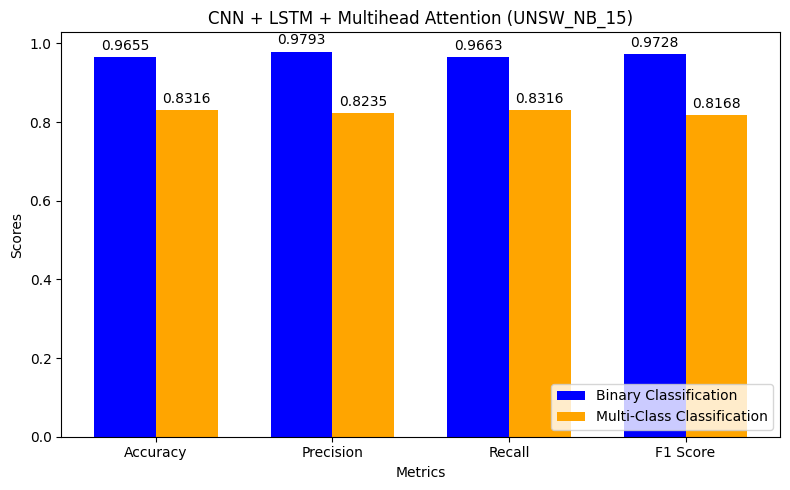

In [ ]:
import matplotlib.pyplot as plt

# Plot the metrics
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
binary_values = [metrics['Binary'][cat] for cat in categories]
multi_class_values = [metrics['Multi-Class'][cat] for cat in categories]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Adjust the size of the plot to a medium size
fig, ax = plt.subplots(figsize=(8, 5))

rects1 = ax.bar(x - width/2, binary_values, width, label='Binary Classification', color='blue')
rects2 = ax.bar(x + width/2, multi_class_values, width, label='Multi-Class Classification', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('CNN + LSTM + Multihead Attention (UNSW_NB_15)')
ax.set_xticks(x)
ax.set_xticklabels(categories)

# Place the legend in the bottom right corner
ax.legend(loc='lower right')

# Function to add labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


In [ ]:
model1 = load_model('/content/drive/MyDrive/unsw-nb15/CNN+Bi-LSTM.h5')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Assuming you have already made predictions
y_pred_binary, y_pred_multi_class = model1.predict(X_test)

# Threshold the binary predictions
y_pred_binary = (y_pred_binary > 0.5).astype(int)

# Evaluate binary classification
binary_accuracy = accuracy_score(y_test_binary, y_pred_binary)
binary_precision = precision_score(y_test_binary, y_pred_binary)
binary_recall = recall_score(y_test_binary, y_pred_binary)
binary_f1 = f1_score(y_test_binary, y_pred_binary)

# Evaluate multi-class classification
y_pred_multi_class = np.argmax(y_pred_multi_class, axis=1)

multi_class_accuracy = accuracy_score(y_test_multi_class, y_pred_multi_class)
multi_class_precision = precision_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_recall = recall_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_f1 = f1_score(y_test_multi_class, y_pred_multi_class, average='weighted')

# Store the metrics
metrics = {
    'Binary': {
        'Accuracy': binary_accuracy,
        'Precision': binary_precision,
        'Recall': binary_recall,
        'F1 Score': binary_f1
    },
    'Multi-Class': {
        'Accuracy': multi_class_accuracy,
        'Precision': multi_class_precision,
        'Recall': multi_class_recall,
        'F1 Score': multi_class_f1
    }
}


1611/1611 [==============================] - 42s 25ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


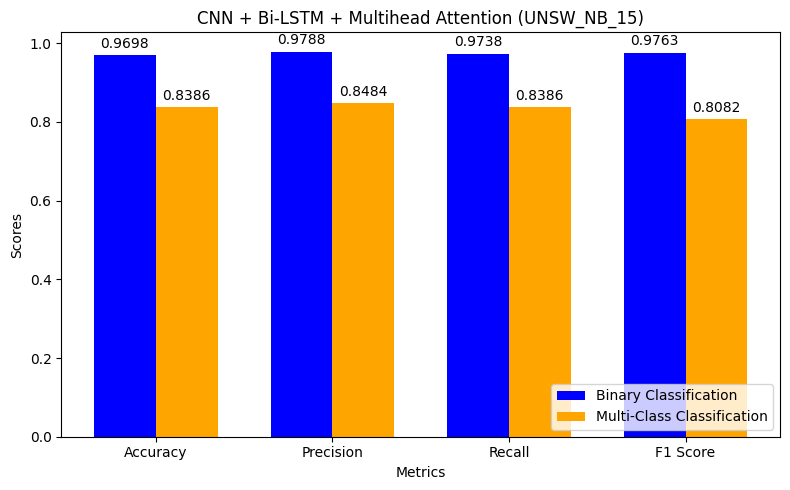

In [ ]:
import matplotlib.pyplot as plt

# Plot the metrics
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
binary_values = [metrics['Binary'][cat] for cat in categories]
multi_class_values = [metrics['Multi-Class'][cat] for cat in categories]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Adjust the size of the plot to a medium size
fig, ax = plt.subplots(figsize=(8, 5))

rects1 = ax.bar(x - width/2, binary_values, width, label='Binary Classification', color='blue')
rects2 = ax.bar(x + width/2, multi_class_values, width, label='Multi-Class Classification', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('CNN + Bi-LSTM + Multihead Attention (UNSW_NB_15)')
ax.set_xticks(x)
ax.set_xticklabels(categories)

# Place the legend in the bottom right corner
ax.legend(loc='lower right')

# Function to add labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


In [ ]:
model7 = load_model('/content/drive/MyDrive/unsw-nb15/CNN+GRU.h5')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Assuming you have already made predictions
y_pred_binary, y_pred_multi_class = model7.predict(X_test)

# Threshold the binary predictions
y_pred_binary = (y_pred_binary > 0.5).astype(int)

# Evaluate binary classification
binary_accuracy = accuracy_score(y_test_binary, y_pred_binary)
binary_precision = precision_score(y_test_binary, y_pred_binary)
binary_recall = recall_score(y_test_binary, y_pred_binary)
binary_f1 = f1_score(y_test_binary, y_pred_binary)

# Evaluate multi-class classification
y_pred_multi_class = np.argmax(y_pred_multi_class, axis=1)

multi_class_accuracy = accuracy_score(y_test_multi_class, y_pred_multi_class)
multi_class_precision = precision_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_recall = recall_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_f1 = f1_score(y_test_multi_class, y_pred_multi_class, average='weighted')

# Store the metrics
metrics = {
    'Binary': {
        'Accuracy': binary_accuracy,
        'Precision': binary_precision,
        'Recall': binary_recall,
        'F1 Score': binary_f1
    },
    'Multi-Class': {
        'Accuracy': multi_class_accuracy,
        'Precision': multi_class_precision,
        'Recall': multi_class_recall,
        'F1 Score': multi_class_f1
    }
}


1611/1611 [==============================] - 21s 12ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


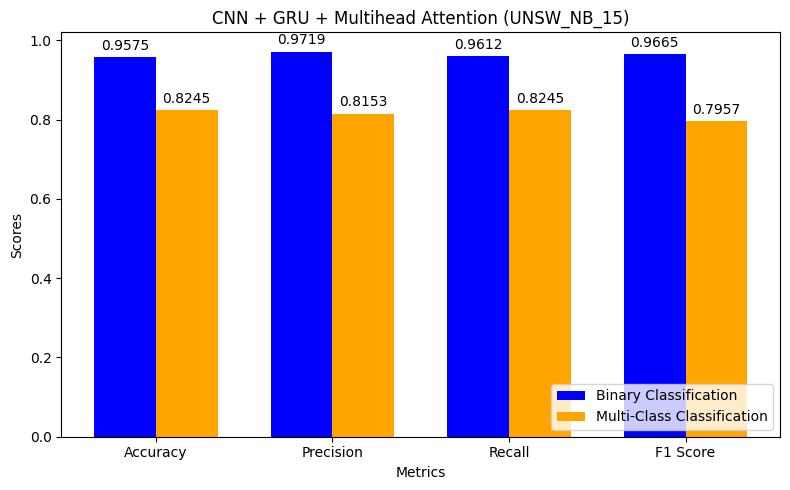

In [ ]:
import matplotlib.pyplot as plt

# Plot the metrics
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
binary_values = [metrics['Binary'][cat] for cat in categories]
multi_class_values = [metrics['Multi-Class'][cat] for cat in categories]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Adjust the size of the plot to a medium size
fig, ax = plt.subplots(figsize=(8, 5))

rects1 = ax.bar(x - width/2, binary_values, width, label='Binary Classification', color='blue')
rects2 = ax.bar(x + width/2, multi_class_values, width, label='Multi-Class Classification', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('CNN + GRU + Multihead Attention (UNSW_NB_15)')
ax.set_xticks(x)
ax.set_xticklabels(categories)

# Place the legend in the bottom right corner
ax.legend(loc='lower right')

# Function to add labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()



In [ ]:
model8 = load_model('/content/drive/MyDrive/unsw-nb15/CNN+Bi-GRU.h5')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Assuming you have already made predictions
y_pred_binary, y_pred_multi_class = model8.predict(X_test)

# Threshold the binary predictions
y_pred_binary = (y_pred_binary > 0.5).astype(int)

# Evaluate binary classification
binary_accuracy = accuracy_score(y_test_binary, y_pred_binary)
binary_precision = precision_score(y_test_binary, y_pred_binary)
binary_recall = recall_score(y_test_binary, y_pred_binary)
binary_f1 = f1_score(y_test_binary, y_pred_binary)

# Evaluate multi-class classification
y_pred_multi_class = np.argmax(y_pred_multi_class, axis=1)

multi_class_accuracy = accuracy_score(y_test_multi_class, y_pred_multi_class)
multi_class_precision = precision_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_recall = recall_score(y_test_multi_class, y_pred_multi_class, average='weighted')
multi_class_f1 = f1_score(y_test_multi_class, y_pred_multi_class, average='weighted')

# Store the metrics
metrics = {
    'Binary': {
        'Accuracy': binary_accuracy,
        'Precision': binary_precision,
        'Recall': binary_recall,
        'F1 Score': binary_f1
    },
    'Multi-Class': {
        'Accuracy': multi_class_accuracy,
        'Precision': multi_class_precision,
        'Recall': multi_class_recall,
        'F1 Score': multi_class_f1
    }
}


1611/1611 [==============================] - 27s 16ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


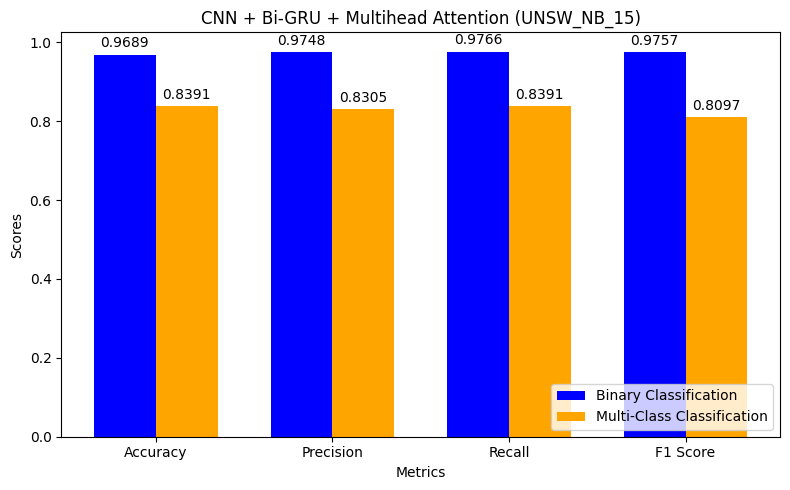

In [ ]:
import matplotlib.pyplot as plt

# Plot the metrics
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
binary_values = [metrics['Binary'][cat] for cat in categories]
multi_class_values = [metrics['Multi-Class'][cat] for cat in categories]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Adjust the size of the plot to a medium size
fig, ax = plt.subplots(figsize=(8, 5))

rects1 = ax.bar(x - width/2, binary_values, width, label='Binary Classification', color='blue')
rects2 = ax.bar(x + width/2, multi_class_values, width, label='Multi-Class Classification', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('CNN + Bi-GRU + Multihead Attention (UNSW_NB_15)')
ax.set_xticks(x)
ax.set_xticklabels(categories)

# Place the legend in the bottom right corner
ax.legend(loc='lower right')

# Function to add labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()
